Link for the Google Colab version of the code file:
https://colab.research.google.com/drive/18lAkuyeEgd4hfITY88iF_O6pXm7jUnAd

# Team Names

Ilia Chanukvadze

Cedric Randriampionona

Varun sai Bera

Christos Gkoritsas

# Team emails

christos.gkoritsas@edhec.com  
ilia.chanukvadze@edhec.com  
varunsai.bera@edhec.com  
cedric.randriamampionona@edhec.com

# Imports and Dependencies

In [ ]:
from google.cloud import bigquery
client = bigquery.Client(project = 'wa-test-project-442216')

In [ ]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd
from scipy.stats import ttest_ind
import scipy.stats as stats
import numpy as np
from scipy.stats import f_oneway
from sklearn.metrics import r2_score
from scipy.stats import chisquare
import copy

# Code samples (not part of the assignment)

## Basic Query

In [ ]:
df1 = client.query('''
SELECT
EXTRACT(HOUR FROM TIMESTAMP_MICROS(event_timestamp)) as hour,
event_value_in_usd as transaction_value
FROM
`bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_202101*`
WHERE
event_name = 'purchase'
AND event_value_in_usd IS NOT null
''').to_dataframe()
df1['hour'] = df1['hour'].astype(float)
df1['transaction_value'] = df1['transaction_value'].astype(float)
print(df1)

NameError: name 'client' is not defined

In [ ]:
# Scatter plot setup
sns.scatterplot(data=df1, x='hour', y='transaction_value')
# Axes and titles
plt.title('Transactions per hour')
plt.xlabel('Hour')
plt.ylabel('# of transactions')
# Chart display
plt.show()

NameError: name 'sns' is not defined

In [ ]:
correlation = df1['hour'].corr(df1['transaction_value'])
print("Correlation coefficient between 'hour' and 'transaction_value':", correlation)

## Student T-Test

In [ ]:
df2 = client.query('''
SELECT
device.category,
event_value_in_usd AS transaction_value
FROM
`bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_202101*`
WHERE
event_name = 'purchase'
AND device.category IN ('mobile', 'desktop')
AND event_value_in_usd IS NOT null
''').to_dataframe()
print(df2)
### df2['transaction_value'] = df2['transaction_value'].astype(float)

In [ ]:
sns.barplot(data=df2, x='category', y='transaction_value', errorbar=None)
plt.title('Average transaction value per device category')
plt.xlabel('Category')
plt.ylabel('Average transaction value')
plt.show()

In [ ]:
mobile_values = df2[df2['category'] == 'mobile']['transaction_value']
desktop_values = df2[df2['category'] == 'desktop']['transaction_value']
shapiro_mobile = stats.shapiro(mobile_values)
shapiro_desktop = stats.shapiro(desktop_values)
print("Shapiro-Wilk for 'mobile':", shapiro_mobile)
print("Shapiro-Wilk for 'desktop':", shapiro_desktop)

As long as pvalue is <0.05 the distribution does not follow a normal distribution

In [ ]:
# Separate groups
mobile_data = df2[df2['category'] == 'mobile']['transaction_value']
desktop_data = df2[df2['category'] == 'desktop']['transaction_value']
# Run T-Test
t_stat, p_value = ttest_ind(mobile_data, desktop_data, equal_var=True)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

NameError: name 'df2' is not defined

## Anova test for impact of device category on transaction value

In [ ]:
df4 = client.query('''
SELECT
device.category,
event_value_in_usd AS transaction_value,
FROM
`bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_202101*`
WHERE
event_name = 'purchase'
AND event_value_in_usd IS NOT null
AND event_value_in_usd < 500
''').to_dataframe()
df4['transaction_value'] = df4['transaction_value'].astype(float)
print(df4)

In [ ]:
sns.barplot(data=df4, x='category', y='transaction_value', estimator='mean')
plt.title('Average transaction per category')
plt.xlabel('Category')
plt.ylabel('Transaction value')
plt.show()

In [ ]:
from scipy.stats import f_oneway
# Exemple : ANOVA pour 'category'
categories = df4['category'].unique()
anova_result = f_oneway(*(df4[df4['category'] == cat]['transaction_value'] for cat in categories))
print("ANOVA result for 'category':", anova_result)

If the p-value <0.05, there is a significative difference between devices categories

# Case 1

**How do users' geographic locations influence average session duration?**

Different countries may have varied levels of engagement based on cultural, economic, or language differences. Understanding session duration by geographic location will help us tailor localized content or campaigns to improve user engagement.

We will extract from the sandbox database the average session duration and the total sessions by user country as well as the continent in which each country belongs to.

Then, we will try to test if the geographic location of a user (country and continent) has a significant impact on the average session duration. Finally, we will compare how a country's session duration compares to its continent's average.

In [ ]:
df1 = client.query('''

WITH session_durations AS ( --We begin by writing a WITH statement to use it afterwards
  SELECT
    user_pseudo_id, --We are choosing the ID of each user
    geo.sub_continent AS user_continent, --We are choosing and defining the geo.sub_continent column
    geo.country AS user_country, --The same for country
    MAX(event_timestamp) - MIN(event_timestamp) AS session_duration --We are finding the session duration for each unique user by subtracting the minimum from the maximum value
  FROM
    `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_202101*` --Data for all of January 2021
  WHERE
    user_pseudo_id IS NOT NULL
    AND geo.country IS NOT NULL --We are avoiding null values for both user id and country
  GROUP BY
    user_pseudo_id, geo.sub_continent, geo.country --We are grouping by all our selected columns to group the session duration values
)
SELECT
  user_country,
  user_continent,
  ROUND(AVG(session_duration) / 60000000, 2) AS avg_session_duration_minutes, -- We transform microseconds to minutes
  COUNT(*) AS total_sessions_per_country --We are counting every observation to create another column for the total sessions for each country
FROM
  session_durations
WHERE
  session_duration / 60000000 <= 1440 --We are excluding sessions longer than 24 hours (1440 minutes) to avoid misleading results
GROUP BY
  user_country, user_continent --We are grouping by country and continent
ORDER BY
  avg_session_duration_minutes DESC; --We are printing the average session duration for each country in descending order

''').to_dataframe()

df1

,user_country,user_continent,avg_session_duration_minutes,total_sessions_per_country
0,Kosovo,Southern Europe,118.96,12
1,Bosnia & Herzegovina,Southern Europe,90.69,15
2,Panama,Central America,82.33,18
3,Macao,Eastern Asia,80.21,16
4,Luxembourg,Western Europe,75.51,17
...,...,...,...,...
117,(not set),Eastern Europe,2.33,22
118,Malta,Southern Europe,1.97,18
119,Trinidad & Tobago,Caribbean,1.72,11
120,Azerbaijan,Western Asia,1.43,35


In [ ]:
# Some descriptive statistics
df1["avg_session_duration_minutes"].describe()

,avg_session_duration_minutes
count,122.000000
mean,32.592295
std,19.477959
min,0.710000
25%,20.792500
50%,32.400000
75%,41.820000
max,118.960000


In [ ]:
df1["total_sessions_per_country"].describe()

,total_sessions_per_country
count,122.0
mean,727.459016
std,3634.656431
min,11.0
25%,33.5
50%,84.0
75%,398.0
max,38915.0


In [ ]:
# Check for NaN values
df1.isnull().sum()

,0
user_country,0
user_continent,0
avg_session_duration_minutes,0
total_sessions_per_country,0


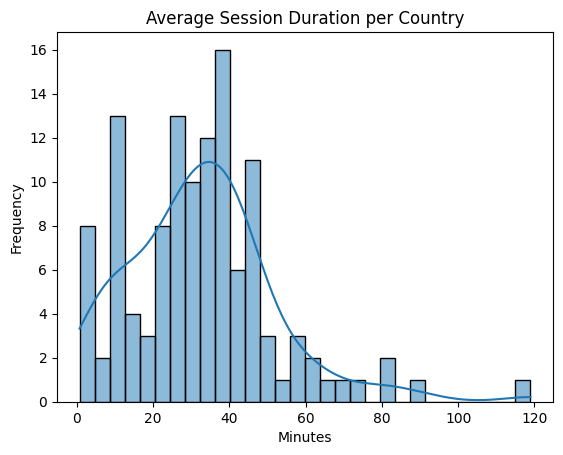

In [ ]:
# Distribution of average session duration
sns.histplot(df1["avg_session_duration_minutes"], kde=True, bins=30) # With KDE we will highlight the overall distribution of the data, we create 30 bins

plt.title("Average Session Duration per Country")
plt.xlabel("Minutes")
plt.ylabel("Frequency")

plt.show()

From what we can see from the histogram, the distribution of the data (average_session) is right-skewed distributed which meand that they are a lot of outliers in the lower bound of the distribution. Let's see how many we have

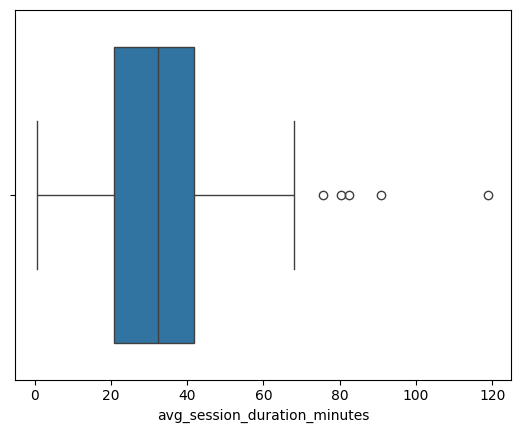

In [ ]:
sns.boxplot(x=df1["avg_session_duration_minutes"])
plt.show()

From the box plot it is clear that there are some outliers in both bounds, but most of them are located in the upper bound

Let's transform it to normal by converting the average session duration to log

In [ ]:
df1["(log)avg_session_duration_minutes"] = np.log(df1["avg_session_duration_minutes"])
df1.head()

,user_country,user_continent,avg_session_duration_minutes,total_sessions_per_country,(log)avg_session_duration_minutes
0,Kosovo,Southern Europe,118.96,12,4.778787
1,Bosnia & Herzegovina,Southern Europe,90.69,15,4.507447
2,Panama,Central America,82.33,18,4.410736
3,Macao,Eastern Asia,80.21,16,4.384648
4,Luxembourg,Western Europe,75.51,17,4.324265


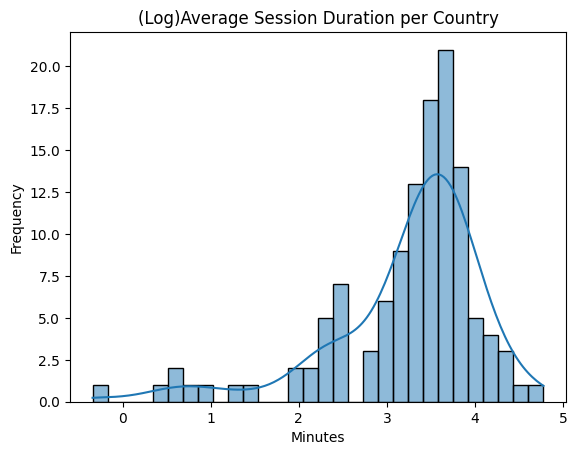

In [ ]:
sns.histplot(df1["(log)avg_session_duration_minutes"], kde=True, bins=30)
plt.title("(Log)Average Session Duration per Country")
plt.xlabel("Minutes")
plt.ylabel("Frequency")

plt.show()

The tranformation of scale in log did not help too much. Let's try now the sqrt transformation

In [ ]:
df1["(sqrt)avg_session_duration_minutes"] = np.sqrt(df1["avg_session_duration_minutes"])
df1.head()

,user_country,user_continent,avg_session_duration_minutes,total_sessions_per_country,(log)avg_session_duration_minutes,(sqrt)avg_session_duration_minutes
0,Kosovo,Southern Europe,118.96,12,4.778787,10.906879
1,Bosnia & Herzegovina,Southern Europe,90.69,15,4.507447,9.523130
2,Panama,Central America,82.33,18,4.410736,9.073588
3,Macao,Eastern Asia,80.21,16,4.384648,8.956004
4,Luxembourg,Western Europe,75.51,17,4.324265,8.689649


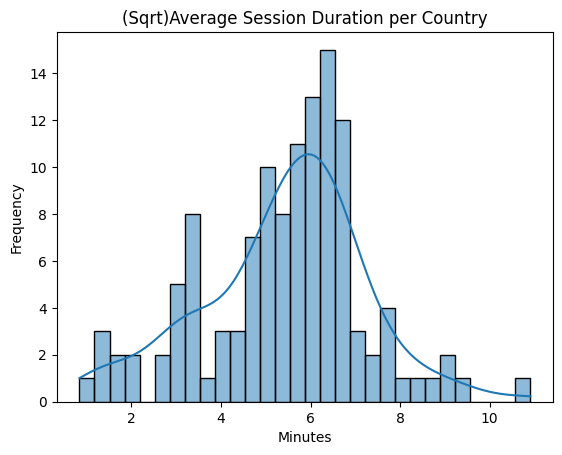

In [ ]:
sns.histplot(df1["(sqrt)avg_session_duration_minutes"], kde=True, bins=30)
plt.title("(Sqrt)Average Session Duration per Country")
plt.xlabel("Minutes")
plt.ylabel("Frequency")

plt.show()

Now the data are more normally distributed than before

At this point we will try to see if the total sessions is related with the average duration of each session in every country in the snadbox's data base. Since correlation is a scale invariant measure we don't need to tranform the variables

In [ ]:
correlation = df1["(sqrt)avg_session_duration_minutes"].corr(df1["total_sessions_per_country"])
print("Correlation (r): ",correlation)

Correlation (r):  0.05251537822438824


We can see that there is no correlation between the variables, so there is no point of performing a linear regression

We will now perform a statistical test to compare the means of session durations between different countries first and then between different continents. We will use the ANOVA instead of t-test as we want to compare the average session duration across multiple geographic locations at once. ANOVA will help us test if there are significant differences in the means of sessions duration between different countries and continents.

Also ANOVA will be identical for this kind of data as they are normally distributed

Null Hypothesis (H₀): The average session durations are the same across all countries

Alternative Hypothesis (H₁): The average session durations differ across at least in one country

We choose significance level at α=0.05

In [ ]:
# We are grouping the data by "user_country" first and perform ANOVA test
countries = df1["user_country"].unique() # We extract all the unique country names from the user_country column
anova_result = f_oneway(*(df1[df1["user_country"] == country]["(sqrt)avg_session_duration_minutes"] for country in countries)) # We iterate through each unique country, we select the "average_session" for each one, we unpack the values and store them

print(anova_result)

F_onewayResult(statistic=0.7903606634996378, pvalue=0.7547233802786066)


p-value is largely bigger than 0.05, so we don't have enough evidence to reject the null hypothesis and we conclude that users' country does not influence the average session duration.

Now let's check for continents

In [ ]:
# We are grouping the data by "user_continent" and perform ANOVA test
continents = df1["user_continent"].unique()
anova_result2 = f_oneway(*(df1[df1["user_continent"] == continent]["(sqrt)avg_session_duration_minutes"] for continent in continents))

print(anova_result2)

F_onewayResult(statistic=0.8255543006927546, pvalue=0.6723987365266693)


For this case p-value is less larger than before but it doesn't change anything. A p-value of 0.67 means that there is approximately 67% chance of observing the differences (or more extreme differences) in the average session duration between continents  purely due to random variation, assuming the null hypothesis is true. Thus, we cannot reject the H0 that users' continent influence the average session duration

All in all we conclude that geographic location (countries and continents) do not have a significant impact on average session duration.

In [ ]:
df1_2 = client.query('''

WITH session_durations AS (
  SELECT
    user_pseudo_id,
    geo.sub_continent AS user_continent,
    geo.country AS user_country,
    MAX(event_timestamp) - MIN(event_timestamp) AS session_duration
  FROM
    `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_202101*`
  WHERE
    user_pseudo_id IS NOT NULL
    AND geo.country IS NOT NULL
  GROUP BY
    user_pseudo_id, geo.sub_continent, geo.country
)
SELECT
  user_country,
  user_continent,
  ROUND(AVG(session_duration) / 60000000, 2) AS avg_session_duration_minutes,
  ROUND(AVG(AVG(session_duration)) OVER (PARTITION BY user_continent) / 60000000, 2) AS avg_continent_session_duration_minutes,
  ROUND(AVG(session_duration) / 60000000 - AVG(AVG(session_duration)) OVER (PARTITION BY user_continent) / 60000000, 2) AS deviation_from_continent_avg_minutes
FROM
  session_durations
WHERE
  session_duration / 60000000 <= 1440
GROUP BY
  user_country, user_continent
ORDER BY
  deviation_from_continent_avg_minutes DESC;

''').to_dataframe()

df1_2.head()

,user_country,user_continent,avg_session_duration_minutes,avg_continent_session_duration_minutes,deviation_from_continent_avg_minutes
0,Kosovo,Southern Europe,118.96,35.99,82.97
1,Bosnia & Herzegovina,Southern Europe,90.69,35.99,54.70
2,Panama,Central America,82.33,28.06,54.27
3,Bahamas,Caribbean,67.95,23.60,44.35
4,Macao,Eastern Asia,80.21,40.03,40.18


In [ ]:
print(df1_2[["avg_session_duration_minutes", "deviation_from_continent_avg_minutes"]].describe())

       avg_session_duration_minutes  deviation_from_continent_avg_minutes
count                    122.000000                            122.000000
mean                      32.592295                              0.000000
std                       19.477959                             18.377718
min                        0.710000                            -34.020000
25%                       20.792500                             -9.852500
50%                       32.400000                             -1.490000
75%                       41.820000                              8.867500
max                      118.960000                             82.970000


We will again create a histogram to visualize our results

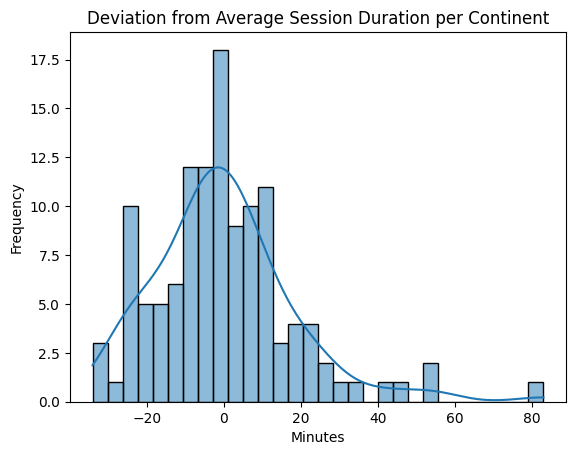

In [ ]:
sns.histplot(df1_2["deviation_from_continent_avg_minutes"], kde=True, bins=30)
plt.title("Deviation from Average Session Duration per Continent")
plt.xlabel("Minutes")
plt.ylabel("Frequency")

plt.show()

Although there are some outliers that make the distribution right skewed, it is easily observed that most of the times the difference between a country's seesion duration average and its continent is 0. This implies that the average session duration for a country is close to its continent average

# Case 2

**Does Device Category Impact Revenue and Purchase Behavior?**

Different device categories (e.g., mobile, desktop) may lead to varied user behaviors due to differences in user experience, screen size, or ease of navigation. Understanding how device categories influence revenue and purchases can guide optimization efforts for each platform.

We will analyse purchases and revenues across device categories to identify significant differences and inform platform-specific strategies.

In [ ]:
df2 = client.query('''

SELECT
    device.category AS device_category, -- Device type (e.g., mobile, desktop)
    COUNTIF(event_name = "purchase") AS total_purchases, -- Count the number of purchase events for each device type
    COUNTIF(event_name = "session_start") AS total_sessions, -- Count the number of session start events for each device type
    SUM((SELECT value.int_value FROM UNNEST(event_params) WHERE key = "value")) AS total_revenue, -- Sum the revenue values for each device type
    AVG((SELECT value.int_value FROM UNNEST(event_params) WHERE key = "value")) AS avg_revenue_per_event -- Calculate the average revenue per event
FROM
    `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_202101*`
GROUP BY
    device_category -- Group results by device type
ORDER BY
    total_revenue DESC; -- Sort the results by total revenue in descending order


''').to_dataframe()

df2

,device_category,total_purchases,total_sessions,total_revenue,avg_revenue_per_event
0,desktop,667,67613,7767,47.359756
1,mobile,508,46342,7724,60.818898
2,tablet,29,2594,239,47.800000


Out of the three device categories, desktop and mobile have almost identical total revenue, while the revenue from tablets is next to non-existent. Even though dekstop devices are leading in total purchases, mobile devices have the higher revenue per event. Let us plot some charts to make the distributions and differences in numbers more clear.

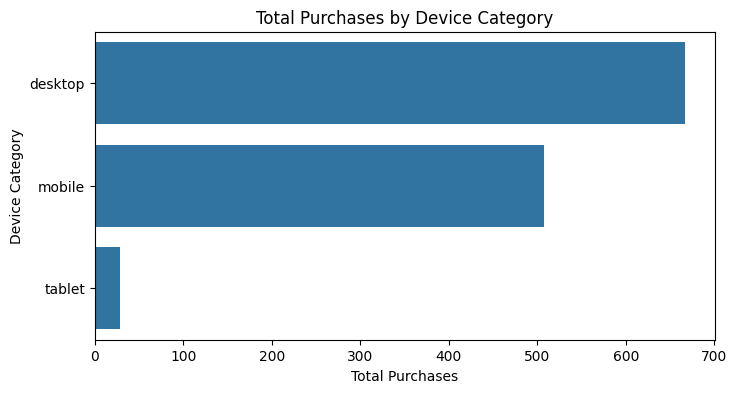

In [ ]:
# Total purchases by device category
plt.figure(figsize=(8, 4))
sns.barplot(data=df2, x="total_purchases", y="device_category", order=df2.sort_values("total_purchases", ascending=False)["device_category"])
plt.title("Total Purchases by Device Category")
plt.xlabel("Total Purchases")
plt.ylabel("Device Category")
plt.show()

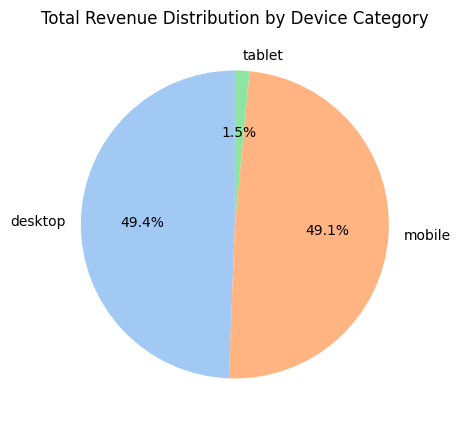

In [ ]:
# Total revenue by device category
plt.figure(figsize=(5, 5))
plt.pie(
    df2["total_revenue"],
    labels=df2["device_category"],
    autopct="%1.1f%%",
    startangle=90,
    colors=sns.color_palette("pastel")
)
plt.title("Total Revenue Distribution by Device Category")
plt.show()

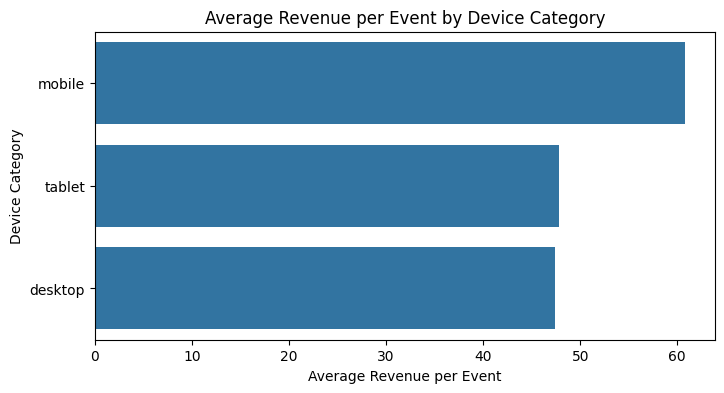

In [ ]:
plt.figure(figsize=(8, 4))
sns.barplot(data=df2, x="avg_revenue_per_event", y="device_category", order=df2.sort_values("avg_revenue_per_event", ascending=False)["device_category"])
plt.title("Average Revenue per Event by Device Category")
plt.xlabel("Average Revenue per Event")
plt.ylabel("Device Category")
plt.show()

Now we will proceed to perform the ANOVA test, but to do so we will first pull the individual purchase rows instead of the aggregated data.

In [ ]:
df2_anova = client.query('''

SELECT
    device.category AS device_category, -- Device type (e.g., mobile, desktop)
    (SELECT value.int_value FROM UNNEST(event_params) WHERE key = "value") AS revenue_value, -- Individual revenue values for purchases
FROM
    `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_202101*`
WHERE
    event_name = "purchase" -- Filter only purchase events

''').to_dataframe()

df2_anova

,device_category,revenue_value
0,desktop,<NA>
1,mobile,<NA>
2,desktop,6
3,mobile,<NA>
4,desktop,<NA>
...,...,...
1199,desktop,<NA>
1200,desktop,<NA>
1201,desktop,94
1202,mobile,<NA>


In [ ]:
# Cheking Nan values
df2_anova.isnull().sum()

,0
device_category,0
revenue_value,908


In [ ]:
# Dropping Nan values
df2_anova = df2_anova.dropna(subset=["revenue_value"])
df2_anova

,device_category,revenue_value
2,desktop,6
7,desktop,12
10,desktop,44
11,desktop,55
13,desktop,44
...,...,...
1179,desktop,23
1181,mobile,115
1186,desktop,24
1191,desktop,80


In [ ]:
# Group revenue values by device category
revenue_desktop = df2_anova[df2_anova["device_category"] == "desktop"]["revenue_value"]
revenue_mobile = df2_anova[df2_anova["device_category"] == "mobile"]["revenue_value"]
revenue_tablet = df2_anova[df2_anova["device_category"] == "tablet"]["revenue_value"]

# Perform ANOVA
anova_result = f_oneway(revenue_desktop, revenue_mobile, revenue_tablet)
print("ANOVA Test Result:", anova_result)

ANOVA Test Result: F_onewayResult(statistic=1.0547916778908801, pvalue=0.34958358622385277)


According to the ANOVA test the F-statistic is equal to 1.05 and the P-value is 0.35, meaning that there is no statistically significant difference in mean revenues across device categories. ultimately this means that device category does not appear to influence revenue significantly in this dataset and the focus to increase revenue stream should be directed somewhere else.

# CASE 3


Identifying Peak Purchase Times and Revenue Distributions. Understanding when users make the most purchases can help optimize marketing campaigns and website performance during peak hours. By analyzing transaction values by hour, we can identify significant patterns that contribute to overall revenue.

In [ ]:
df3 = client.query('''
SELECT
  hour,
  SUM(transaction_value) AS total_revenue,
  COUNT(transaction_value) AS transaction_count,
  AVG(transaction_value) AS avg_transaction_value,
  SUM(SUM(transaction_value)) OVER (ORDER BY hour) AS cumulative_revenue
FROM (
  SELECT
    EXTRACT(HOUR FROM TIMESTAMP_MICROS(event_timestamp)) AS hour,
    event_value_in_usd AS transaction_value
  FROM
    `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_202101*`
  WHERE
    event_name = 'purchase'
    AND event_value_in_usd IS NOT NULL
) AS hourly_transactions
GROUP BY
  hour
ORDER BY
  hour;
''').to_dataframe()

print(df3)

    hour  total_revenue  transaction_count  avg_transaction_value  \
0      0         2656.0                 42              63.238095   
1      1         3244.0                 37              87.675676   
2      2         1660.0                 26              63.846154   
3      3         2152.0                 33              65.212121   
4      4         2392.0                 44              54.363636   
5      5         2442.0                 44              55.500000   
6      6         2291.0                 37              61.918919   
7      7         1592.0                 27              58.962963   
8      8         2317.0                 33              70.212121   
9      9         2390.0                 40              59.750000   
10    10         1875.0                 29              64.655172   
11    11         1688.0                 25              67.520000   
12    12         1396.0                 26              53.692308   
13    13         3176.0           

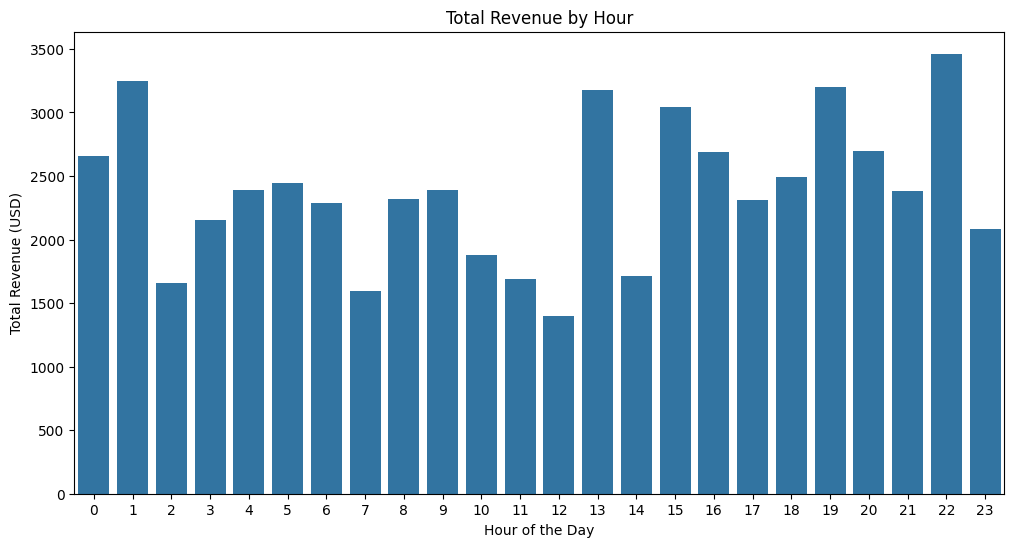

In [ ]:
# 1. Bar Chart for Total Revenue by Hour
plt.figure(figsize=(12, 6))
sns.barplot(x=df3['hour'], y=df3['total_revenue'])
plt.title('Total Revenue by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Total Revenue (USD)')
plt.show()


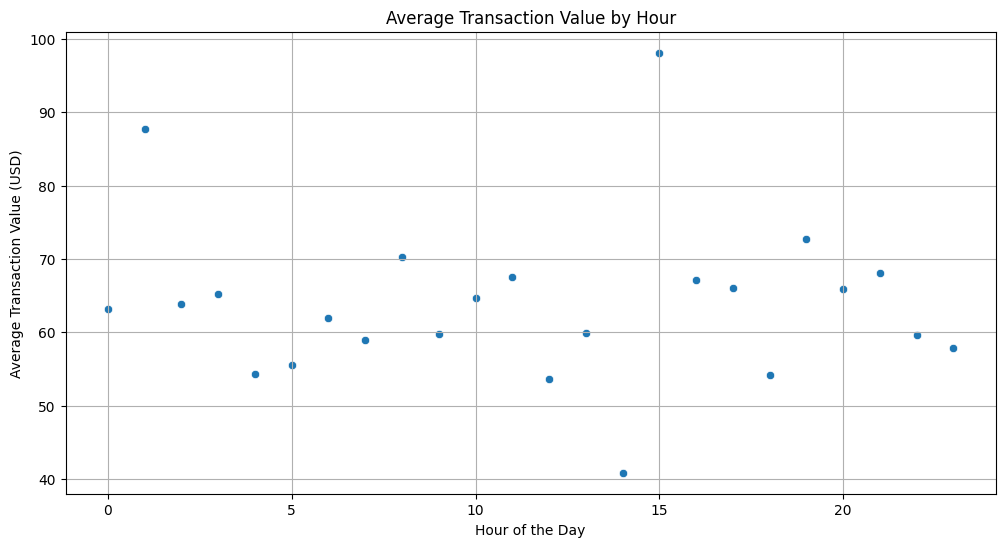

In [ ]:
# 3. Scatter Plot for Average Transaction Value by Hour
plt.figure(figsize=(12, 6))
sns.scatterplot(x=df3['hour'], y=df3['avg_transaction_value'])
plt.title('Average Transaction Value by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Transaction Value (USD)')
plt.grid(True)
plt.show()

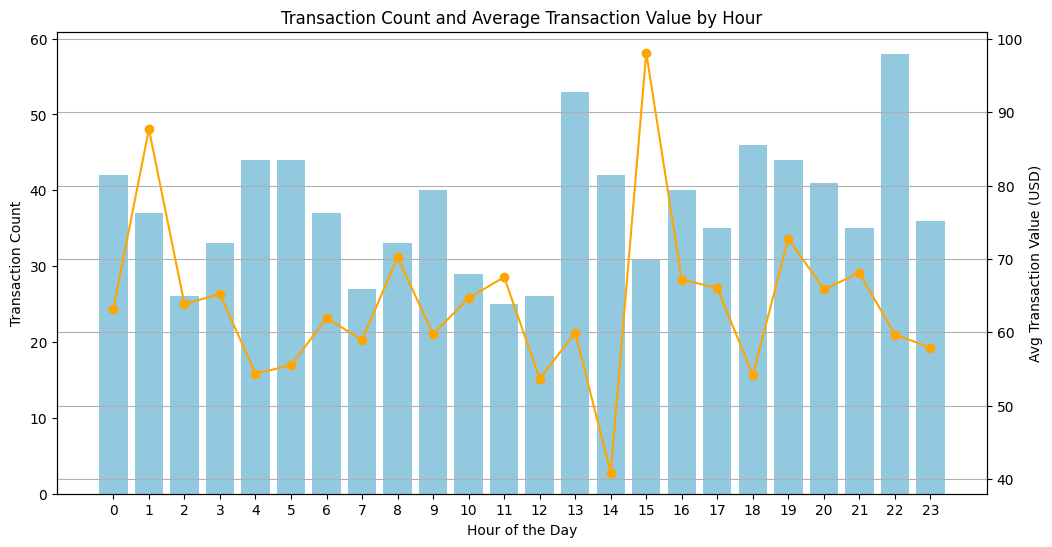

In [ ]:
# 4. Dual Axis Plot for Transaction Count and Average Value
fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()

sns.barplot(x=df3['hour'], y=df3['transaction_count'], color='skyblue', ax=ax1)
ax2.plot(df3['hour'], df3['avg_transaction_value'], color='orange', marker='o')

ax1.set_xlabel('Hour of the Day')
ax1.set_ylabel('Transaction Count')
ax2.set_ylabel('Avg Transaction Value (USD)')
plt.title('Transaction Count and Average Transaction Value by Hour')
plt.grid(True)
plt.show()

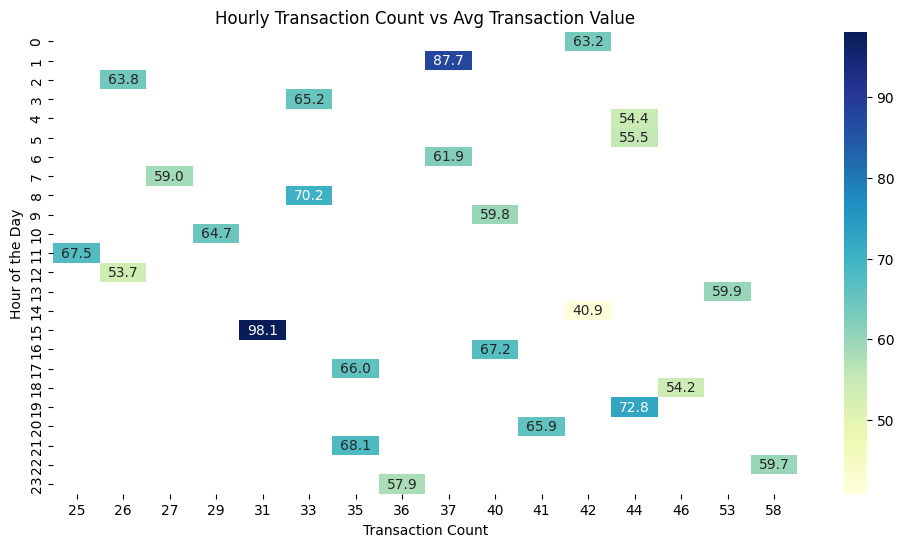

In [ ]:
#5 . Heat Map
plt.figure(figsize=(12, 6))
pivot = df3.pivot(index="hour", columns="transaction_count", values="avg_transaction_value") # Added index, columns and value parameters to the pivot function
sns.heatmap(pivot, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title('Hourly Transaction Count vs Avg Transaction Value')
plt.xlabel('Transaction Count')
plt.ylabel('Hour of the Day')
plt.show()


This is more useful to understand and visualize the distribution of transactions across the day to highlight peak hours clearly.

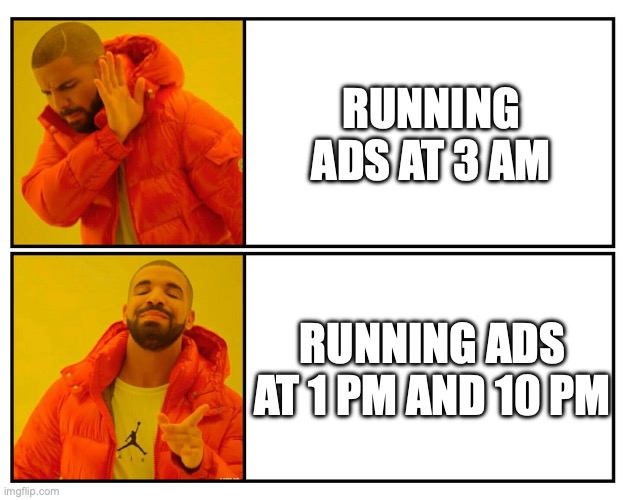

Transactions peak at 1 PM and 10 PM, while 3 PM shows the highest average transaction value, suggesting fewer but larger purchases. Early morning hours between 3 AM to 6 AM reflect minimal activity. Cumulative revenue shows steady growth throughout the day, with significant spikes around peak hours. Marketing efforts should focus on afternoon and evening hours to maximize revenue, while promotions during low-activity periods could boost engagement

Statistical Testing (ANOVA)

In [ ]:
# Group data by time period
morning = df3[df3['hour'] < 12]['avg_transaction_value']
afternoon = df3[(df3['hour'] >= 12) & (df3['hour'] < 18)]['avg_transaction_value']
evening = df3[df3['hour'] >= 18]['avg_transaction_value']

# Perform ANOVA test
anova_result = stats.f_oneway(morning, afternoon, evening)

# Output Result
print("ANOVA Result:", anova_result)

if anova_result.pvalue < 0.05:
    print("Significant difference in average transaction values between time periods.")
else:
    print("No significant difference in average transaction values between time periods.")

ANOVA Result: F_onewayResult(statistic=0.027091158963227793, pvalue=0.973306472152856)
No significant difference in average transaction values between time periods.


**The ANOVA result indicates no statistically significant difference in average transaction values between morning, afternoon, and evening periods (p-value = 0.973). This suggests that the average transaction value is relatively consistent throughout the day.**

# Case 4:

**Exploration of conversion rate: do factors such as browser, session length, or item category have an impact on conversion rate?**

In [ ]:
df4_browser = client.query('''

WITH
  device_info AS (
  SELECT
    device.web_info.browser as browser,
    (SELECT value.int_value FROM UNNEST(event_params) WHERE key = 'ga_session_id') AS session_id,
    event_name
  FROM
    `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_202101*`
    ),
  session_durations AS (
  SELECT
    (SELECT value.int_value FROM UNNEST(event_params) WHERE key = 'ga_session_id') AS session_id,
    MAX(event_timestamp) - MIN(event_timestamp) AS session_duration
  FROM
    `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_202101*`
   GROUP BY
    session_id
)

SELECT
  browser,
  ROUND(AVG(session_duration) / 60000000, 2) AS avg_session_duration_minutes,
  ROUND(COUNT(IF(event_name = 'purchase', 1, NULL)) / COUNT(device_info.session_id),4)*100 AS conversion_rate
  FROM device_info INNER JOIN session_durations ON device_info.session_id = session_durations.session_id
  WHERE
  session_duration / 60000000 <= 1440 --We are excluding sessions longer than 24 hours (1440 minutes) to avoid misleading results
  GROUP BY 1
  ORDER BY avg_session_duration_minutes DESC

''').to_dataframe()

df4_browser

,browser,avg_session_duration_minutes,conversion_rate
0,Firefox,39.52,0.10
1,Chrome,38.66,0.10
2,Safari,36.44,0.10
3,Edge,34.22,0.08
4,<Other>,33.19,0.10
5,Android Webview,28.61,0.14


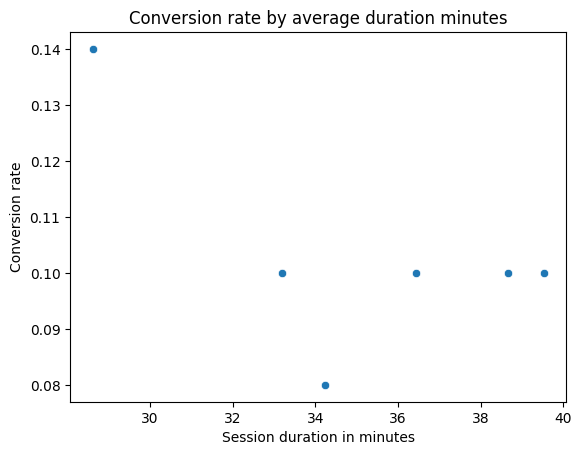

In [ ]:
# 1. Scatter plot of conversion rate by time spent
sns.scatterplot(x=df4_browser['avg_session_duration_minutes'], y=df4_browser['conversion_rate'])
plt.title('Conversion rate by average duration minutes')
plt.xlabel('Session duration in minutes')
plt.ylabel('Conversion rate')
plt.show()

In [ ]:
correlation = df4_browser['avg_session_duration_minutes'].corr(df4_browser['conversion_rate'])
print('Correlation between time spent and conversion rate:', correlation)

Correlation between time spent and conversion rate: -0.6135839775416874


Time spent seems to have a negative impact on conversion rate. Users who spend the most time browsing the website seem less likely to purchase something (maybe because they are indecisive or could not find what they wanted).

In [ ]:
# Let's run an ANOVA test for the impact of browser on conversion rate
# First we need to split the dataset by sessions instead of browsers.

df4_session_id = client.query('''

WITH
  device_info AS (
  SELECT
    device.web_info.browser as browser,
    (SELECT value.int_value FROM UNNEST(event_params) WHERE key = 'ga_session_id') AS session_id,
    event_name
  FROM
    `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_202101*`
    ),
  session_durations AS (
  SELECT
    (SELECT value.int_value FROM UNNEST(event_params) WHERE key = 'ga_session_id') AS session_id,
    MAX(event_timestamp) - MIN(event_timestamp) AS session_duration
  FROM
    `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_202101*`
   GROUP BY
    session_id
)

SELECT
  browser,
  device_info.session_id,
  ROUND(session_duration/ 60000000, 2) AS session_duration_minutes,
  COUNT(IF(event_name = 'purchase', 1, NULL)) AS conversion
  FROM device_info INNER JOIN session_durations ON device_info.session_id = session_durations.session_id
  WHERE
  session_duration / 60000000 <= 1440 --We are excluding sessions longer than 24 hours (1440 minutes) to avoid misleading results
  GROUP BY all

  ORDER BY session_duration_minutes DESC

''').to_dataframe()

df4_session_id

,browser,session_id,session_duration_minutes,conversion
0,Safari,7871006806,1433.95,0
1,<Other>,7871006806,1433.95,0
2,Chrome,7871006806,1433.95,0
3,Chrome,9775076493,1427.30,0
4,Chrome,5312025510,1420.89,0
...,...,...,...,...
116431,Chrome,4688467975,0.00,0
116432,Chrome,3093533621,0.00,0
116433,Chrome,1660270772,0.00,0
116434,Chrome,7514172687,0.00,0


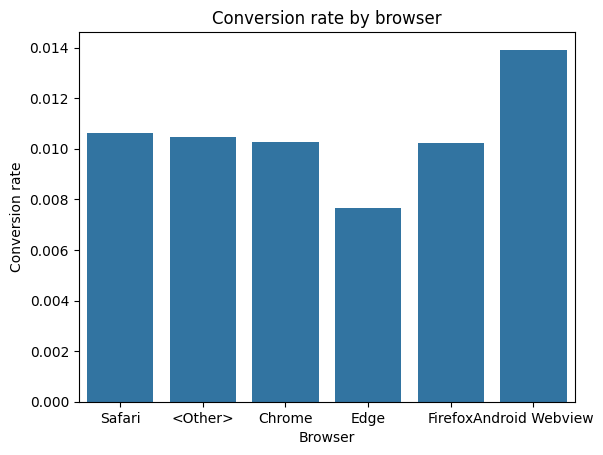

ANOVA result for browser: F_onewayResult(statistic=0.5916218600586746, pvalue=0.7064441586993282)


In [ ]:
conversion_rate = {}
browsers = df4_session_id['browser'].unique()

for browser in browsers:
  conversion_rate[browser] = df4_session_id[df4_session_id['browser'] == browser]['conversion'].sum() / df4_session_id[df4_session_id['browser'] == browser]['conversion'].count()

sns.barplot(conversion_rate)
plt.title('Conversion rate by browser')
plt.xlabel('Browser')
plt.ylabel('Conversion rate')
plt.show()


anova_result = f_oneway(*(df4_session_id[df4_session_id['browser'] == browser]['conversion'] for browser in browsers))
print("ANOVA result for browser:", anova_result)


{'Safari': 26.764852878312908, '<Other>': 24.528484451718494, 'Chrome': 20.480990965913406, 'Edge': 31.450496752006117, 'Firefox': 30.182014890646812, 'Android Webview': 28.960914512922457}


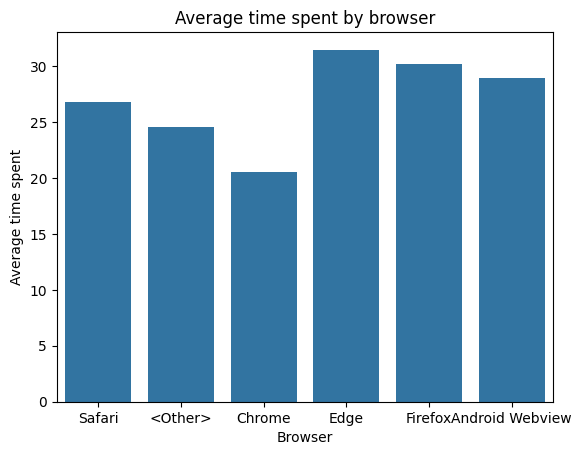

ANOVA result for browser: F_onewayResult(statistic=17.269241654913877, pvalue=3.988619129044258e-17)


In [ ]:
avg_time_spent = {}

for browser in browsers:
  avg_time_spent[browser] = df4_session_id[df4_session_id['browser'] == browser]['session_duration_minutes'].mean()

print(avg_time_spent)

sns.barplot(avg_time_spent)
plt.title('Average time spent by browser')
plt.xlabel('Browser')
plt.ylabel('Average time spent')
plt.show()


anova_result = f_oneway(*(df4_session_id[df4_session_id['browser'] == browser]['session_duration_minutes'] for browser in browsers))
print("ANOVA result for browser:", anova_result)


From these tests we see that conversion rate and average time spent are about evenly distributed across browsers. Meaning that based on these factors customers seem to have a similar experience on the website regardless of browsers which is a good sign.

In [ ]:
df4_category = client.query('''

WITH
  item_info AS (
  SELECT
    item,
    (SELECT value.int_value FROM UNNEST(event_params) WHERE key = 'ga_session_id') AS session_id,
    event_name
  FROM
    `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_202101*`,
    UNNEST(items) AS item
    ),
  session_durations AS (
  SELECT
    (SELECT value.int_value FROM UNNEST(event_params) WHERE key = 'ga_session_id') AS session_id,
    MAX(event_timestamp) - MIN(event_timestamp) AS session_duration
  FROM
    `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_202101*`
   GROUP BY
    session_id
),
session_with_purchase AS (
    SELECT DISTINCT
        session_id,
        item.item_category
    FROM item_info
    WHERE event_name = 'purchase'
),
category_sessions AS (
  SELECT DISTINCT
      item_info.session_id,
      item.item_category
  FROM item_info
)
SELECT
  category_sessions.item_category AS item_category,
  ROUND(AVG(session_duration) / 60000000, 2) AS avg_session_duration_minutes,
  ROUND(COUNTIF(session_with_purchase.session_id IS NOT NULL) / COUNT(DISTINCT category_sessions.session_id),4)*100 AS conversion_rate
  FROM category_sessions INNER JOIN session_durations ON category_sessions.session_id = session_durations.session_id
  LEFT JOIN session_with_purchase ON category_sessions.session_id = session_with_purchase.session_id AND category_sessions.item_category = session_with_purchase.item_category
  WHERE
  session_duration / 60000000 <= 1440 --We are excluding sessions longer than 24 hours (1440 minutes) to avoid misleading results
  GROUP BY item_category
  ORDER BY avg_session_duration_minutes DESC

''').to_dataframe()

df4_category

,item_category,avg_session_duration_minutes,conversion_rate
0,Fun/,303.48,0.00
1,Fun,96.39,45.45
2,Eco-Friendly,58.04,0.00
3,Lifestyle/Small Goods/,54.58,0.00
4,Small Goods,54.34,4.17
...,...,...,...
69,Kid's-Infant/,5.83,0.00
70,Men's Warm Gear/,4.03,0.00
71,More Bags/,3.89,0.00
72,Electronics/,1.21,0.00


Unfortunately, Google's website places items in multiple categories for example, the Googgle Analytics logs the fun items as "Fun/" or "Fun", which renders this breakdown less helpful than we would like.

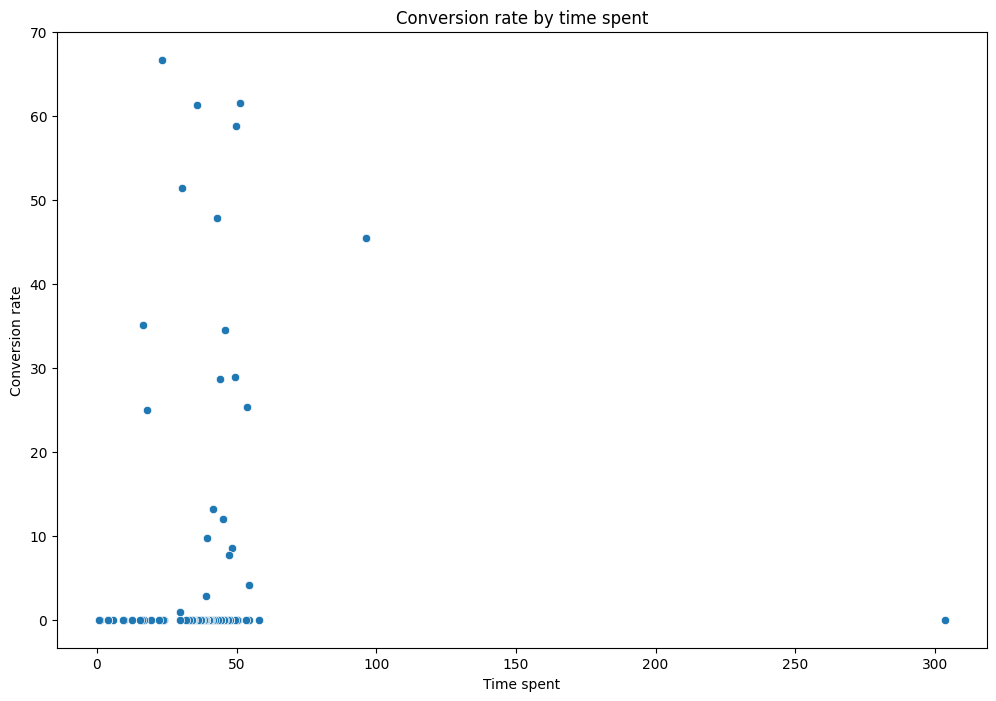

In [ ]:
# 2. Scatter plot of conversion rate by time spent for categories
plt.figure(figsize=(12, 8))
sns.scatterplot(x=df4_category['avg_session_duration_minutes'], y=df4_category['conversion_rate'])
plt.title('Conversion rate by time spent')
plt.xlabel('Time spent')
plt.ylabel('Conversion rate')
plt.show()

From this point of view we see that there are categories with a significant time spent yet no conversion rate. Let's try to look at the categories that do generate purchases for now.

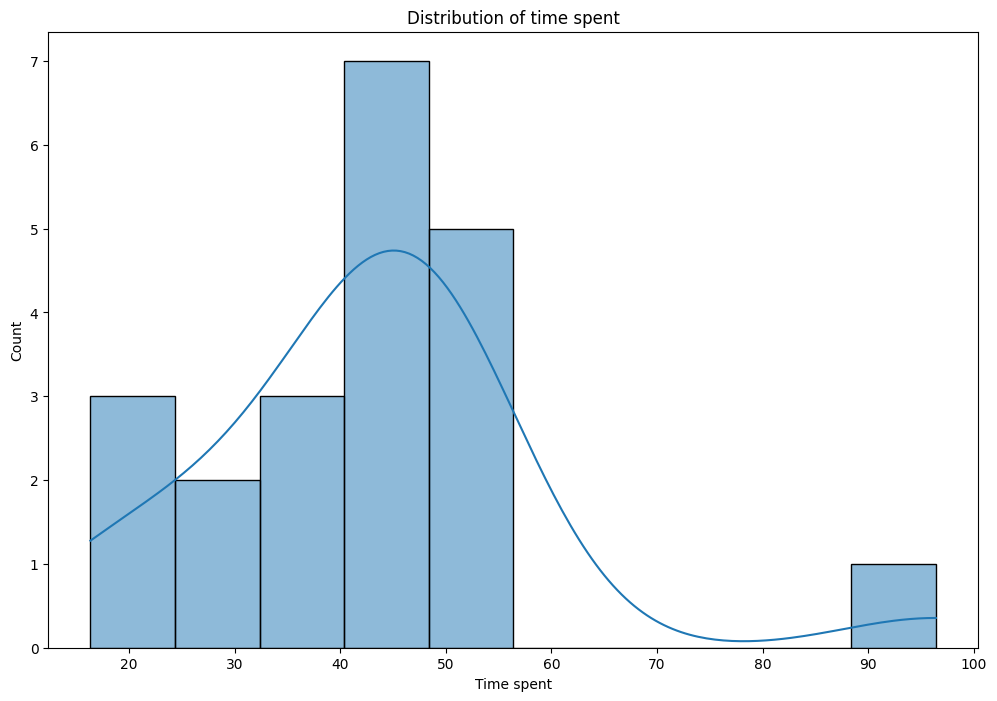

In [ ]:
# if we exclude them
df4_category_filtered = df4_category[df4_category['conversion_rate'] > 0]

# and plot a histogram
plt.figure(figsize=(12, 8))
sns.histplot(df4_category_filtered['avg_session_duration_minutes'],bins = 10, kde=True)
plt.title('Distribution of time spent')
plt.xlabel('Time spent')
plt.show()

To test for normality let's draw a QQ-plot.

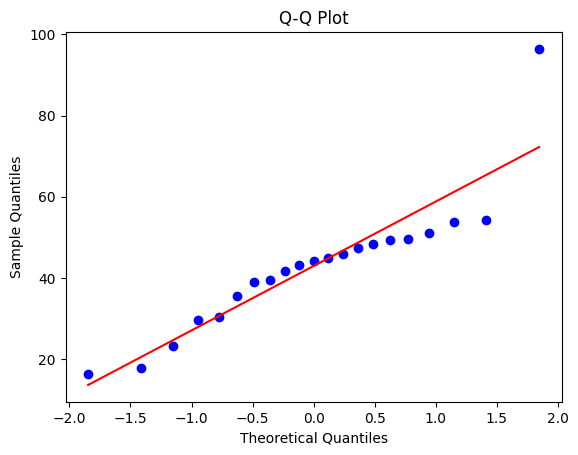

In [ ]:
stats.probplot(df4_category_filtered['avg_session_duration_minutes'], dist="norm", plot=plt)
plt.title('Q-Q Plot')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.show()

Average time spent per category is not normally distributed which makes sense, users spend more time looking at certain items than others.

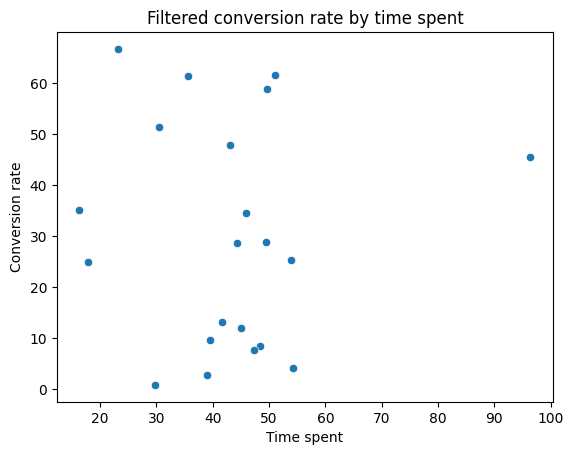

In [ ]:
# Still looking at the table of time spent per category let's look at the relationship between average session length and conversion rate
plt.figsize=(12, 8)
sns.scatterplot(x=df4_category_filtered['avg_session_duration_minutes'], y=df4_category_filtered['conversion_rate'])
plt.title('Filtered conversion rate by time spent')
plt.xlabel('Time spent')
plt.ylabel('Conversion rate')
plt.show()

In [ ]:
correlation_category_filtered = df4_category_filtered['avg_session_duration_minutes'].corr(df4_category_filtered['conversion_rate'])
print('Correlation between time spent and conversion rate:', correlation_category_filtered)

Correlation between time spent and conversion rate: 0.004862722790757924


This time we see that there is no clear relationship between session length and conversion rate. It appears that despite some categories having more time spent in than others, time spent in a category does not indicate likelihood of purchase.